In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load
from glob import glob
from sklearn.metrics import classification_report

In [2]:
matrix = "cbuckle"
df = pd.read_csv(f"data/{matrix}_1000_testing.csv")
df.head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
0,cbuckle.mat,341,0.000001,34100,12766,133,798,9.993116e-07,True,0.553754,373.369101,13681,2.340176
1,cbuckle.mat,341,0.000001,34100,9685,293,358,9.810659e-07,True,0.253908,485.237722,13681,1.049853
2,cbuckle.mat,341,0.000001,34100,2906,80,355,9.727220e-07,True,0.277555,99.923192,13681,1.041056
3,cbuckle.mat,341,0.000001,34100,10030,45,384,9.812118e-07,True,0.272684,373.369101,13681,1.126100
4,cbuckle.mat,341,0.000001,34100,9582,310,7608,9.999793e-07,True,5.194308,38410.569328,13681,22.310850


In [3]:
df.sort_values("slowdown", inplace=False, ascending=False).head()

,mat_name,errorfree_iterations,tol,maxiter,error_pos,error_iter,solve_iterations,final_relres,did_converge,realtime_s,pos_2norm,n_rows,slowdown
602,cbuckle.mat,341,0.000001,34100,7589,134,34099,0.005933,False,22.651335,39365.780756,13681,99.997067
853,cbuckle.mat,341,0.000001,34100,7247,215,34099,0.000002,False,22.695046,40881.724908,13681,99.997067
44,cbuckle.mat,341,0.000001,34100,11442,216,34099,0.000010,False,22.773293,35846.965555,13681,99.997067
337,cbuckle.mat,341,0.000001,34100,2958,140,34099,0.000002,False,22.506243,39981.119838,13681,99.997067
480,cbuckle.mat,341,0.000001,34100,13139,223,34099,0.000005,False,22.654016,39981.119838,13681,99.997067


In [4]:
X_test = df[["error_iter", "pos_2norm"]].to_numpy()
y_test = df["slowdown"].to_numpy()

In [5]:
p = 1 / 98
1 + (1 / p)

# 1 + (1 / x) = 99
# (1 / x) = 98
# x = 1 / 98

99.00000000000001

In [6]:
models = [load(fn) for fn in glob(f"./models/{matrix}/*.pkl")]
model_names = [model.steps[-1][1].__class__.__name__ for model in models]
ps = list(np.arange(1 / 98, 1, 0.01))

reports = pd.DataFrame(index=ps, columns=model_names)
reports.head()

,RandomForestRegressor,XGBRegressor,KNeighborsRegressor,LinearSVR,Ridge
0.010204,NaN,NaN,NaN,NaN,NaN
0.020204,NaN,NaN,NaN,NaN,NaN
0.030204,NaN,NaN,NaN,NaN,NaN
0.040204,NaN,NaN,NaN,NaN,NaN
0.050204,NaN,NaN,NaN,NaN,NaN


In [7]:
for p in ps:
    for model, name in zip(models, model_names):
        preds = model.predict(X_test)
        y_pred_clas = preds > (1 + (1 / p))
        y_true_clas = y_test > (1 + (1 / p))
        reports.loc[p][name] = classification_report(y_true_clas, y_pred_clas, 
                                                     zero_division=0, output_dict=True)

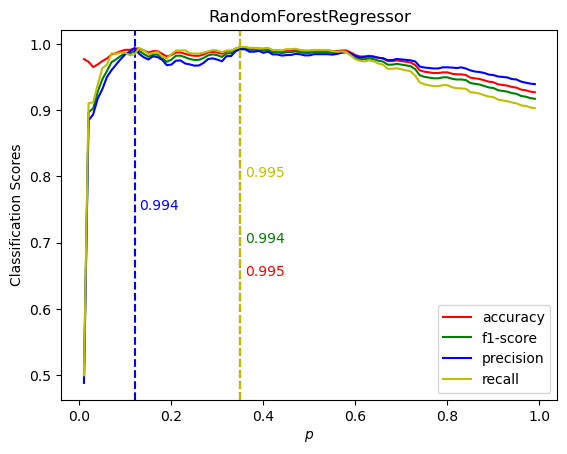

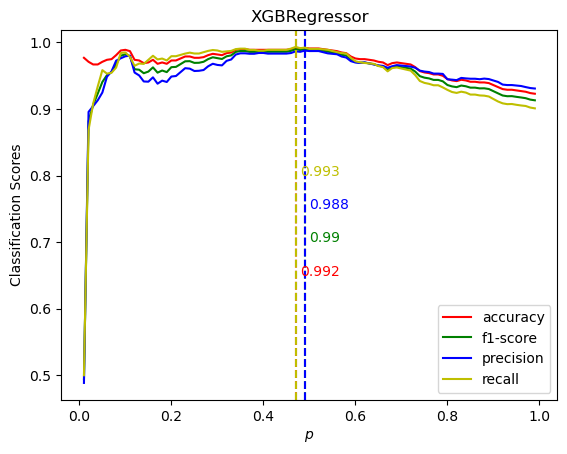

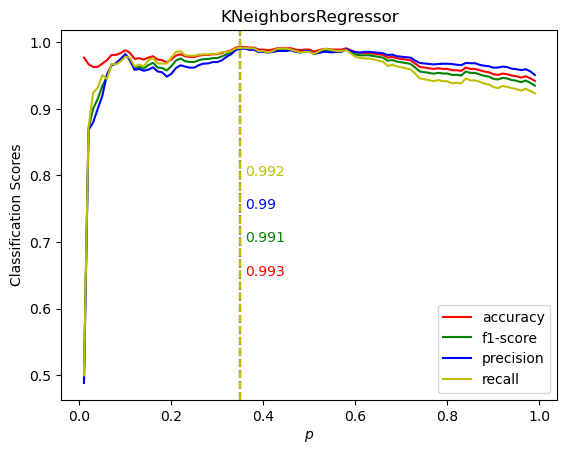

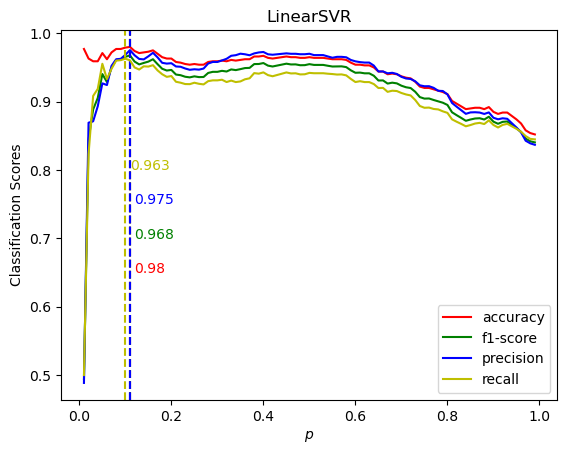

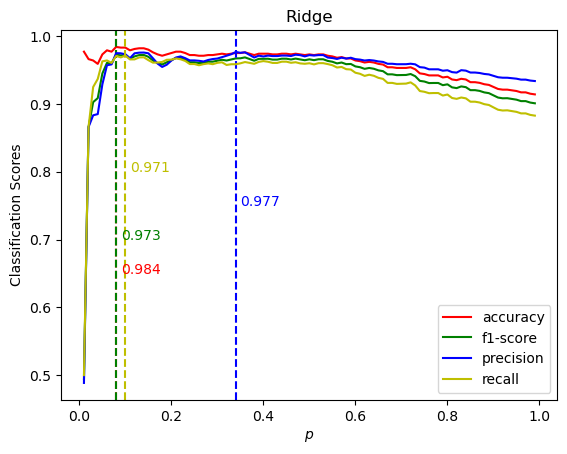

In [8]:
for name, series in reports.items():
    accuracies = [item["accuracy"] for item in series]
    best_acc_p = ps[np.argmax(accuracies)]
    scores = [item["macro avg"] for item in series]
    f1_scores = [score["f1-score"] for score in scores]
    best_f1_p = ps[np.argmax(f1_scores)]
    precisions = [score["precision"] for score in scores]
    best_precision_p = ps[np.argmax(precisions)]
    recalls = [score["recall"] for score in scores]
    best_recall_p = ps[np.argmax(recalls)]

    plt.plot(ps, accuracies, label=f"accuracy", c="r")
    plt.axvline(x=best_acc_p, linestyle='--', c="r")
    plt.annotate(f"{round(np.max(accuracies), 3)}", xy=(best_acc_p + 0.01, 0.65), c="r")

    plt.plot(ps, f1_scores, label=f"f1-score", c="g")
    plt.axvline(x=best_f1_p, linestyle='--', c="g")
    plt.annotate(f"{round(np.max(f1_scores), 3)}", xy=(best_f1_p + 0.01, 0.7), c="g")

    plt.plot(ps, precisions, label=f"precision", c="b")
    plt.axvline(x=best_precision_p, linestyle='--', c="b")
    plt.annotate(f"{round(np.max(precisions), 3)}", xy=(best_precision_p + 0.01, 0.75), c="b")

    plt.plot(ps, recalls, label=f"recall", c="y")
    plt.axvline(x=best_recall_p, linestyle='--', c="y")
    plt.annotate(f"{round(np.max(recalls), 3)}", xy=(best_recall_p + 0.01, 0.8), c="y")

    plt.title(name)
    plt.xlabel("$p$")
    plt.ylabel("Classification Scores")
    plt.legend()
    os.makedirs(f"./figures/{matrix}", exist_ok=True)
    plt.savefig(f"./figures/{matrix}/{name}.png")
    plt.show()